In [1]:
from AC import preproc
from AC import get_news
import inspect
import nltk
nltk.download("stopwords")

%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Cristy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
economia = get_news("./articoli_economia/")
cultura = get_news("./articoli_cultura/")
tech = get_news("./articoli_tech/")
politica = get_news("./articoli_politica/")
sport = get_news("./articoli_sport/")
cronaca = get_news("./articoli_cronaca/")

for articolo in economia:
    articolo['categoria'] = "Economia"
for articolo in cultura:
    articolo['categoria'] = "Cultura"
for articolo in tech:
    articolo['categoria'] = "Tech"
for articolo in politica:
    articolo['categoria'] = "Politica"
for articolo in sport:
    articolo['categoria'] = "Sport"
for articolo in cronaca:
    articolo['categoria'] = "Cronaca"
dati_preprocessati =  preproc(tech + politica + cultura + economia + sport + cronaca)

100%|██████████| 2400/2400 [00:36<00:00, 91.76it/s]


In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
seed = 0
train_documents,test_documents = train_test_split(dati_preprocessati,random_state=seed)
test_documents, val_documents = train_test_split(test_documents,random_state=seed,train_size=0.5)

C:\Users\Cristy\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [5]:
docs_texts = [' '.join([word for word in x['testo']] + x['tags'] + x['sottotitolo'] + x['titolo_articolo']) for x in dati_preprocessati]
train_texts = [' '.join([word for word in x['testo']] + x['sottotitolo'] + x['titolo_articolo']) for x in train_documents]
test_texts = [' '.join([word for word in x['testo']] + x['sottotitolo'] + x['titolo_articolo']) for x in test_documents]
val_texts = [' '.join([word for word in x['testo']] + x['sottotitolo'] + x['titolo_articolo']) for x in val_documents]

docs_cats = [x["categoria"] for x in dati_preprocessati]
train_cats = [x["categoria"] for x in train_documents]
test_cats = [x["categoria"] for x in test_documents]
val_cats = [x["categoria"] for x in val_documents]

In [13]:
from sklearn.pipeline import Pipeline
from sklearn import linear_model,metrics


ldac = Pipeline([
    ("count_mx",CountVectorizer(max_features=1000000, lowercase=True)),
    ("lda", LatentDirichletAllocation(max_iter=50, learning_method='online',random_state=0)),
    ("classifier",DecisionTreeClassifier(random_state=0))
])
params = {
    'count_mx__ngram_range': (1, 1),
    'count_mx__min_df': 6,
    'count_mx__max_df': 0.5,
    'lda__n_components':12,
    'lda__learning_decay':0.7,
    'classifier__min_samples_leaf': 1,
    'classifier__max_depth': 40 #non so se cambia qualcosa ma forse e' utile per n_components=96
}
ldac.set_params(**params)
res = []
for i in [6,12,24,48,96]:
    params = {'lda__n_components': i}
    ldac.set_params(**params)
    ldac.fit(train_texts, train_cats)
    pred_cats = ldac.predict(test_texts)
    res.append({'lda__n_components': i,"accuracy_score":metrics.accuracy_score(test_cats, pred_cats)})
    print(i)


6
12
24
48
96


,accuracy_score,lda__n_components
0,0.990000,6
1,0.993333,12
2,0.990000,24
3,0.990000,48
4,0.996667,96


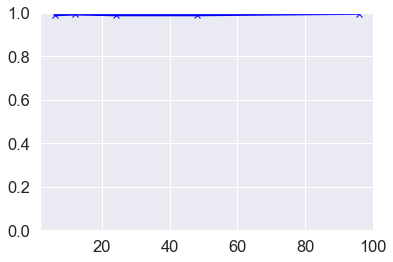

In [14]:
res = pd.DataFrame(res).sort_values(["lda__n_components","accuracy_score"], ascending=[True,False])
display(res)
plt.ylim((0,1))
plt.plot(res["lda__n_components"],res["accuracy_score"],'xb-')

In [15]:
ldac = Pipeline([
    ("count_mx",CountVectorizer(max_features=1000000, lowercase=True)),
    ("lda", LatentDirichletAllocation(max_iter=50, learning_method='online',random_state=0)),
    ("classifier",DecisionTreeClassifier(random_state=0))
])
params = {
    'count_mx__ngram_range': (1, 3),
    'count_mx__min_df': 10,
    'count_mx__max_df': 0.5,
    'lda__n_components':12,
    'lda__learning_decay':0.7,
    'classifier__min_samples_leaf': 1,
    'classifier__max_depth': 40
}
ldac.set_params(**params)
res = []
for i in [6,12,24,48,96]:
    params = {'lda__n_components': i}
    ldac.set_params(**params)
    ldac.fit(train_texts, train_cats)
    pred_cats = ldac.predict(test_texts)
    res.append({'lda__n_components': i,"accuracy_score":metrics.accuracy_score(test_cats, pred_cats)})
    print(i)

6
12
24
48
96


,accuracy_score,lda__n_components
0,0.996667,6
1,0.990000,12
2,0.996667,24
3,0.990000,48
4,0.996667,96


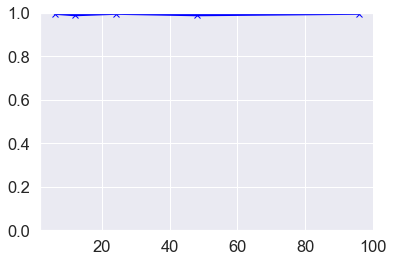

In [16]:
res = pd.DataFrame(res).sort_values(["lda__n_components","accuracy_score"], ascending=[True,False])
display(res)
plt.ylim((0,1))
plt.plot(res["lda__n_components"],res["accuracy_score"],'xb-')
